Using data from nevena flat line removal

In [120]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
# --- Data Loading ---
directory_path = r'/home/ryan/Documents/CBI/nesscan_fixed_removed_flat_lines_03312025/bobHallPier'
dataframes = []
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['date', 'pwl']
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])
bhp = bhp[bhp['date'] >= pd.to_datetime('1996-01-01')]
bhp = bhp.reset_index(drop=True)

# --- Remove obvious outliers using ±4 from median ---
median_val = bhp['pwl'].median()
bhp.loc[np.abs(bhp['pwl'] - median_val) > 4, 'pwl'] = np.nan
pd.set_option("display.max_columns", None)

In [121]:

pwl = bhp['pwl']
s = lambda x: pwl.shift(x)

# --- Compute All 8 Third Differences ---
bhp['3DF']    = s(3)  - 3 * s(2)  + 3 * s(1)  - s(0)
bhp['3DFm1']  = s(4)  - 3 * s(3)  + 3 * s(2)  - s(0)
bhp['3DFm2']  = s(4)  - 3 * s(3)  + 3 * s(1)  - s(0)
bhp['3DFm3']  = s(4)  - 3 * s(2)  + 3 * s(1)  - s(0)

bhp['3DB']    = s(-3) - 3 * s(-2) + 3 * s(-1) - s(0)
bhp['3DBm1']  = s(-4) - 3 * s(-3) + 3 * s(-2) - s(0)
bhp['3DBm2']  = s(-4) - 3 * s(-3) + 3 * s(-1) - s(0)
bhp['3DBm3']  = s(-3) - 3 * s(-2) + 3 * s(-1) - s(0)

third_diff_cols = ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']
bhp[third_diff_cols] = bhp[third_diff_cols].round(4)

# Flag each 3D if it exceeds ±6 STD
def create_flag_column(df, col):
    std = df[col].std(skipna=True)
    mean = df[col].mean(skipna=True)
    upper = mean + 6 * std
    lower = mean - 6 * std

    return (
        (df[col].isna()) | 
        (df[col] == 0) | 
        (df[col] > upper) | 
        (df[col] < lower)
    ).astype(int)

third_diff_flag_cols = [f'{col}_flag' for col in third_diff_cols]
for col in third_diff_cols:
    bhp[f'{col}_flag'] = create_flag_column(bhp, col)

# Create suspect flag
bhp['suspect_flag'] = bhp[third_diff_cols].isna().all(axis=1).astype(int)

# Clean using only the third diff flags (not repeat/spike)
bhp['pwl_cleaned'] = np.where(
    bhp[third_diff_flag_cols].sum(axis=1) > 0,
    np.nan,
    bhp['pwl']
)
bhp.loc[bhp['suspect_flag'] == 1, 'pwl_cleaned'] = np.nan

false positive check

In [122]:
forward_flags  = ['3DF_flag', '3DFm1_flag', '3DFm2_flag', '3DFm3_flag']
backward_flags = ['3DB_flag', '3DBm1_flag', '3DBm2_flag', '3DBm3_flag']

bhp['false_positive_exception'] = (
    ((bhp[forward_flags].sum(axis=1) > 0) & (bhp[backward_flags].sum(axis=1) == 0)) |
    ((bhp[backward_flags].sum(axis=1) > 0) & (bhp[forward_flags].sum(axis=1) == 0))
).astype(int)

bhp.loc[bhp['false_positive_exception'] == 1, 'pwl_cleaned'] = bhp.loc[bhp['false_positive_exception'] == 1, 'pwl']

repeat check

In [123]:
for col in ['spike_pass', 'spike_repeat_flag', 'spike_flag']:
    if col not in bhp.columns:
        bhp[col] = 0

# Now get all flag columns (excluding suspect)
all_flag_cols = [col for col in bhp.columns if col.endswith('_flag') and col != 'suspect_flag']

# Get rows where any flag is set
flagged_rows = bhp[all_flag_cols].any(axis=1)
flagged_indices = bhp.index[flagged_rows]

for i in flagged_indices:
    spike_val = bhp.at[i, 'pwl']
    pass_val = bhp.at[i, 'spike_pass']
    if pd.isna(spike_val):
        continue

    # Forward
    j = i + 1
    while j < len(bhp) and bhp.at[j, 'pwl'] == spike_val:
        if bhp.loc[j, 'spike_flag'] == 0:
            bhp.at[j, 'spike_repeat_flag'] = 1
            bhp.at[j, 'spike_flag'] = 1
            bhp.at[j, 'spike_pass'] = pass_val
            bhp.at[j, 'pwl_cleaned'] = np.nan
        j += 1

    # Backward
    j = i - 1
    while j >= 0 and bhp.at[j, 'pwl'] == spike_val:
        if bhp.loc[j, 'spike_flag'] == 0:
            bhp.at[j, 'spike_repeat_flag'] = 1
            bhp.at[j, 'spike_flag'] = 1
            bhp.at[j, 'spike_pass'] = pass_val
            bhp.at[j, 'pwl_cleaned'] = np.nan
        j -= 1


# Move pwl_cleaned to end
pwl_cleaned_col = bhp.pop('pwl_cleaned')
bhp['pwl_cleaned'] = pwl_cleaned_col
bhp = bhp.drop(columns=['spike_pass', 'spike_flag'])


Nan Check

In [124]:
third_diff_flag_cols = [f'{col}_flag' for col in third_diff_cols]
for col in third_diff_cols:
    bhp[f'{col}_flag'] = create_flag_column(bhp, col)

has_all_fwd = bhp[forward_flags].notna().sum(axis=1) == len(forward_flags)
has_all_bwd = bhp[backward_flags].notna().sum(axis=1) == len(backward_flags)

n_fwd = bhp[forward_flags].sum(axis=1)
n_bwd = bhp[backward_flags].sum(axis=1)

bhp['final_keep'] = (
    ((n_fwd > 0) & (n_bwd == 0) & has_all_bwd) |
    ((n_bwd > 0) & (n_fwd == 0) & has_all_fwd) |
    ((n_fwd == 0) & (n_bwd == 0))  # No flags at all
).astype(int)
bhp.loc[bhp['final_keep'] == 0, 'pwl_cleaned'] = np.nan


In [125]:
threshold = 2
bhp['gradient_flag'] = 0

pwl_values = bhp['pwl_cleaned'].values
n = len(pwl_values)
i = 1

while i < n:
    prev_val = pwl_values[i - 1]
    curr_val = pwl_values[i]

    if pd.isna(prev_val) or pd.isna(curr_val):
        i += 1
        continue

    diff = abs(curr_val - prev_val)

    if diff > threshold:
        # Spike detected
        baseline = prev_val
        bhp.at[i, 'gradient_flag'] = 1
        bhp.at[i, 'pwl_cleaned'] = np.nan

        # Forward check
        j = i + 1
        while j < n:
            val = pwl_values[j]
            if pd.isna(val):
                j += 1
                continue

            if abs(val - baseline) > threshold:
                bhp.at[j, 'gradient_flag'] = 1
                bhp.at[j, 'pwl_cleaned'] = np.nan
                j += 1
            else:
                break  # Value returned to near-baseline

        i = j  # Jump ahead to avoid double-counting
    else:
        i += 1


In [126]:
bhp[576620:576670]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,false_positive_exception,spike_repeat_flag,pwl_cleaned,final_keep,gradient_flag
576620,2002-07-30 14:00:00,6.658,0.002,0.015,0.018,0.003,-0.031,-0.046,-0.052,-0.031,0,0,0,0,0,0,0,0,0,0,0,6.658,1,0
576621,2002-07-30 14:06:00,6.627,0.020,0.033,0.018,0.015,-0.015,0.023,0.011,-0.015,0,0,0,0,0,0,0,0,0,0,0,6.627,1,0
576622,2002-07-30 14:12:00,6.629,-0.059,0.018,-0.075,-0.060,0.021,-0.008,0.019,0.021,0,0,0,0,0,0,0,0,0,0,0,6.629,1,0
576623,2002-07-30 14:18:00,6.633,0.031,-0.063,-0.057,0.036,-0.012,0.011,0.014,-0.012,0,0,0,0,0,0,0,0,0,0,0,6.633,1,0
576624,2002-07-30 14:24:00,6.624,0.015,0.040,0.052,0.046,0.020,-0.021,-0.006,0.020,0,0,0,0,0,0,0,0,0,0,0,6.624,1,0
576625,2002-07-30 14:30:00,6.623,-0.021,0.016,-0.011,-0.023,-0.020,-0.029,-0.062,-0.020,0,0,0,0,0,0,0,0,0,0,0,6.623,1,0
576626,2002-07-30 14:36:00,6.618,0.012,-0.016,-0.019,0.008,-0.024,0.076,0.055,-0.024,0,0,0,0,0,0,0,0,0,0,0,6.618,1,0
576627,2002-07-30 14:42:00,6.629,-0.020,0.001,-0.014,-0.011,0.065,-3.900,-3.837,0.065,0,0,0,0,0,1,1,0,0,1,0,6.629,1,0
576628,2002-07-30 14:48:00,6.636,0.020,-0.027,0.006,0.021,-3.907,7.703,7.655,-3.907,0,0,0,0,1,1,1,1,0,1,0,6.636,1,0
576629,2002-07-30 14:54:00,6.615,0.024,0.041,0.062,0.029,7.724,-3.838,7.724,7.724,0,0,0,0,1,1,1,1,0,1,0,6.615,1,0


In [127]:
bhp['suspect_flag'].sum() - bhp['pwl'].isna().sum()

np.int64(306)

In [128]:
bhp['spike_repeat_flag'].sum()

np.int64(11385)

Text(0, 0.5, 'Freq')

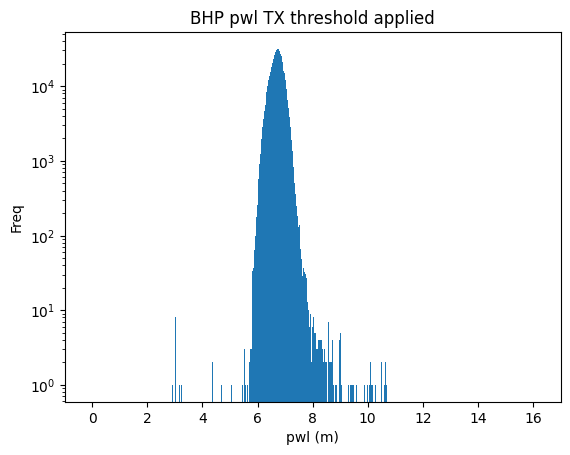

In [129]:
plt.hist(bhp['pwl'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl TX threshold applied')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

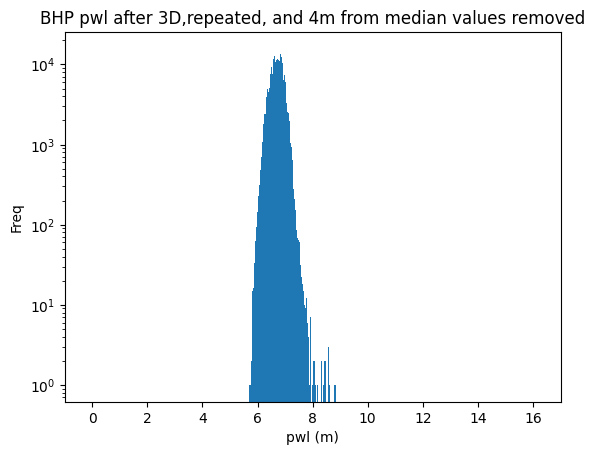

In [130]:
plt.hist(bhp['pwl_cleaned'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl after 3D,repeated, and 4m from median values removed')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

In [131]:
bhp['pwl_cleaned'].idxmax()

149619

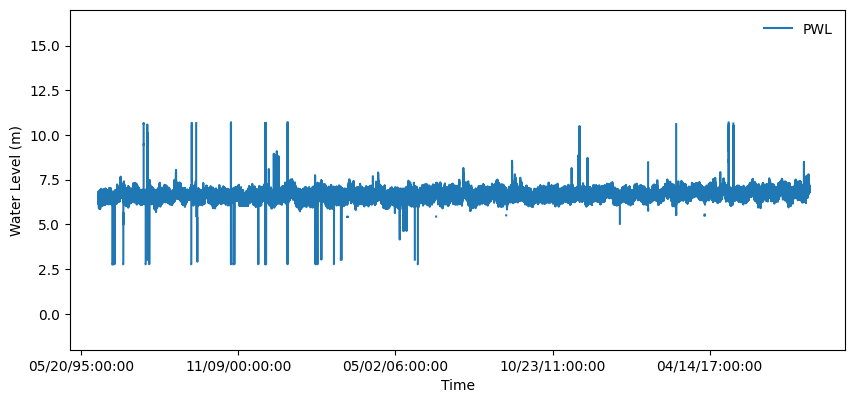

In [132]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

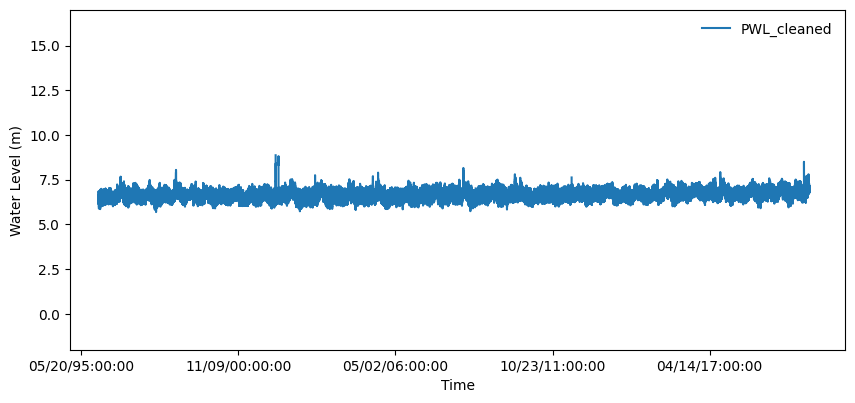

In [133]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

Need to find a way to handle the values after a gap, maybe switching to a forward pass at those locations

In [134]:
bhp[41420:41450]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,false_positive_exception,spike_repeat_flag,pwl_cleaned,final_keep,gradient_flag
41420,1996-06-21 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41421,1996-06-21 14:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41422,1996-06-21 14:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41423,1996-06-21 14:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41424,1996-06-21 14:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41425,1996-06-21 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41426,1996-06-21 14:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41427,1996-06-21 14:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41428,1996-06-21 14:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0
41429,1996-06-21 14:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,NaN,0,0


In [135]:
bhp['pwl_cleaned'].isna().sum() - bhp['pwl'].isna().sum()

np.int64(15014)

In [136]:
suspects_df = bhp.dropna(subset=['pwl'])
suspects_df['suspect_flag'].sum()

np.int64(306)

In [137]:
for col in ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']:
    mean = bhp[col].mean(skipna=True)
    std = bhp[col].std(skipna=True)
    upper = mean + 6 * std
    lower = mean - 6 * std
    print(f"{col}: mean={mean:.4f}, std={std:.4f}, range=({lower:.4f}, {upper:.4f})")


3DF: mean=0.0000, std=0.1025, range=(-0.6148, 0.6148)
3DFm1: mean=-0.0000, std=0.0985, range=(-0.5907, 0.5907)
3DFm2: mean=0.0001, std=0.1004, range=(-0.6022, 0.6023)
3DFm3: mean=-0.0000, std=0.0998, range=(-0.5985, 0.5985)
3DB: mean=-0.0000, std=0.1025, range=(-0.6148, 0.6148)
3DBm1: mean=0.0000, std=0.0998, range=(-0.5985, 0.5985)
3DBm2: mean=-0.0001, std=0.1004, range=(-0.6023, 0.6022)
3DBm3: mean=-0.0000, std=0.1025, range=(-0.6148, 0.6148)


In [138]:
bhp['pwl_cleaned'].idxmax()

149619

In [139]:
bhp[137190:137220]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,false_positive_exception,spike_repeat_flag,pwl_cleaned,final_keep,gradient_flag
137190,1997-07-25 15:00:00,6.553,0.039,0.016,0.019,0.013,0.061,-0.024,0.036,0.061,0,0,0,0,0,0,0,0,0,0,0,6.553,1,0
137191,1997-07-25 15:06:00,6.560,-0.086,0.032,-0.085,-0.088,-0.031,-0.020,-0.062,-0.031,0,0,0,0,0,0,0,0,0,0,0,6.560,1,0
137192,1997-07-25 15:12:00,6.540,0.073,-0.066,-0.045,0.072,-0.000,-0.031,-0.082,-0.000,0,0,0,0,1,0,0,1,0,1,0,6.540,1,0
137193,1997-07-25 15:18:00,6.554,-0.061,0.059,-0.001,-0.022,-0.045,0.051,-0.009,-0.045,0,0,0,0,0,0,0,0,0,0,0,6.554,1,0
137194,1997-07-25 15:24:00,6.571,0.031,-0.078,-0.036,0.024,0.034,0.075,0.141,0.034,0,0,0,0,0,0,0,0,0,0,0,6.571,1,0
137195,1997-07-25 15:30:00,6.591,0.000,0.011,0.062,0.020,0.055,-0.094,-0.004,0.055,1,0,0,0,0,0,0,0,0,1,0,6.591,1,0
137196,1997-07-25 15:36:00,6.569,0.045,0.022,0.082,0.031,-0.072,4.127,4.076,-0.072,0,0,0,0,0,1,1,0,0,1,0,6.569,1,0
137197,1997-07-25 15:42:00,6.539,-0.034,0.075,0.009,-0.051,4.157,-8.250,-8.226,4.157,0,0,0,0,1,1,1,1,0,1,0,6.539,1,0
137198,1997-07-25 15:48:00,6.556,-0.055,-0.051,-0.141,-0.075,-8.267,4.127,-8.245,-8.267,0,0,0,0,1,1,1,1,0,1,0,6.556,1,0
137199,1997-07-25 15:54:00,6.548,0.072,-0.047,0.004,0.094,4.135,4.111,4.144,4.135,0,0,0,0,1,1,1,1,0,1,0,6.548,1,0


In [140]:
bhp['pwl_cleaned'].idxmax()

149619

In [141]:
bhp[543860:543880]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,false_positive_exception,spike_repeat_flag,pwl_cleaned,final_keep,gradient_flag
543860,2002-03-16 02:00:00,6.599,0.005,0.003,0.009,0.003,0.012,-0.020,0.016,0.012,0,0,0,0,0,0,0,0,0,0,0,6.599,1,0
543861,2002-03-16 02:06:00,6.586,0.005,0.018,0.009,0.003,-0.007,-0.026,-0.029,-0.007,0,0,0,0,0,0,0,0,0,0,0,6.586,1,0
543862,2002-03-16 02:12:00,6.574,-0.011,0.017,-0.022,-0.013,-0.014,0.010,-0.011,-0.014,0,0,0,0,0,0,0,0,0,0,0,6.574,1,0
543863,2002-03-16 02:18:00,6.575,-0.012,-0.012,-0.048,-0.009,0.009,0.002,0.005,0.009,0,0,0,0,0,0,0,0,0,0,0,6.575,1,0
543864,2002-03-16 02:24:00,6.582,0.007,-0.019,-0.016,0.020,-0.005,0.006,0.006,-0.005,0,0,0,0,0,0,0,0,0,0,0,6.582,1,0
543865,2002-03-16 02:30:00,6.581,0.014,0.008,0.029,0.026,0.007,-0.005,0.007,0.007,0,0,0,0,0,0,0,0,0,0,0,6.581,1,0
543866,2002-03-16 02:36:00,6.581,-0.009,0.014,0.011,-0.010,-0.005,-0.004,-0.001,-0.005,0,0,0,0,0,0,0,0,0,0,0,6.581,1,0
543867,2002-03-16 02:42:00,6.577,0.005,-0.005,-0.005,-0.002,-0.000,-0.002,0.007,-0.000,0,0,0,0,1,0,0,1,0,1,0,6.577,1,0
543868,2002-03-16 02:48:00,6.576,-0.007,0.006,-0.006,-0.006,-0.001,2.517,2.532,-0.001,0,0,0,0,0,1,1,0,0,1,0,6.576,1,0
543869,2002-03-16 02:54:00,6.573,0.005,-0.004,-0.007,0.005,2.520,-5.011,-4.987,2.520,0,0,0,0,1,1,1,1,0,1,0,6.573,1,0


In [143]:
bhp[149600:149640]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,false_positive_exception,spike_repeat_flag,pwl_cleaned,final_keep,gradient_flag
149600,1997-09-15 08:00:00,8.413,1.896,-1.456,1.163,1.088,3.212,-1.568,3.175,3.212,1,1,1,1,1,1,1,1,0,0,0,NaN,0,0
149601,1997-09-15 08:06:00,8.458,-1.268,1.851,1.326,-1.293,-1.613,-1.536,-1.551,-1.613,1,1,1,1,1,1,1,1,0,0,0,NaN,0,0
149602,1997-09-15 08:12:00,6.877,1.846,0.313,0.448,0.973,0.045,-0.008,0.058,0.045,1,0,0,1,0,0,0,0,0,1,0,6.877,1,0
149603,1997-09-15 08:18:00,6.882,-3.212,1.841,-2.902,-3.037,-0.013,-0.022,-0.010,-0.013,1,1,1,1,0,0,0,0,0,1,0,6.882,1,0
149604,1997-09-15 08:24:00,6.860,1.613,-3.190,-3.175,1.568,-0.000,1.056,1.053,-0.000,1,1,1,1,1,1,1,1,0,0,0,NaN,0,0
149605,1997-09-15 08:30:00,6.856,-0.045,1.617,1.551,1.536,1.060,-2.210,-2.228,1.060,0,1,1,1,1,1,1,1,0,0,0,NaN,0,0
149606,1997-09-15 08:36:00,6.857,0.013,-0.046,-0.058,0.008,-2.211,1.481,-1.732,-2.211,0,0,0,0,1,1,1,1,0,1,0,6.857,1,0
149607,1997-09-15 08:42:00,6.863,0.000,0.007,0.010,0.022,1.475,0.506,0.731,1.475,1,0,0,0,1,0,1,1,0,0,0,NaN,0,0
149608,1997-09-15 08:48:00,7.934,-1.060,-1.071,-1.053,-1.056,-0.565,-1.125,-1.887,-0.565,1,1,1,1,0,1,1,0,0,0,0,NaN,0,0
149609,1997-09-15 08:54:00,7.859,2.211,-0.985,2.228,2.210,-1.050,3.519,3.465,-1.050,1,1,1,1,1,1,1,1,0,0,0,NaN,0,0


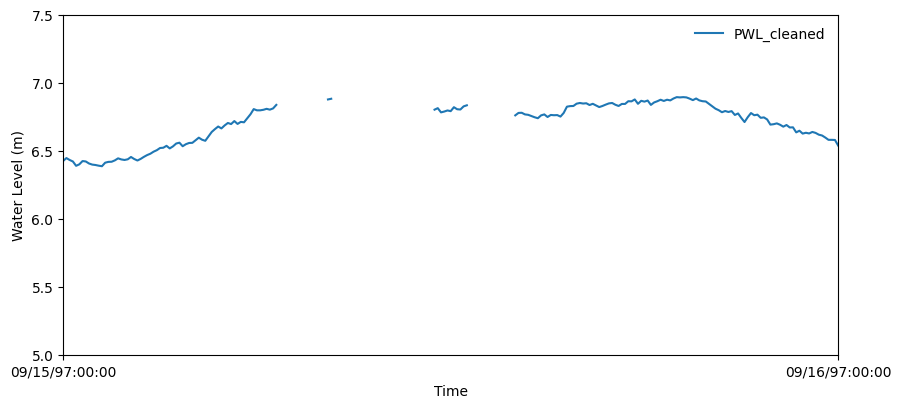

In [147]:
start_date = pd.to_datetime('1997-09-15 00:00:00')
end_date = pd.to_datetime('1997-09-16 00:00:00')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')
#plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL_cleaned')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(5,7.5)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()